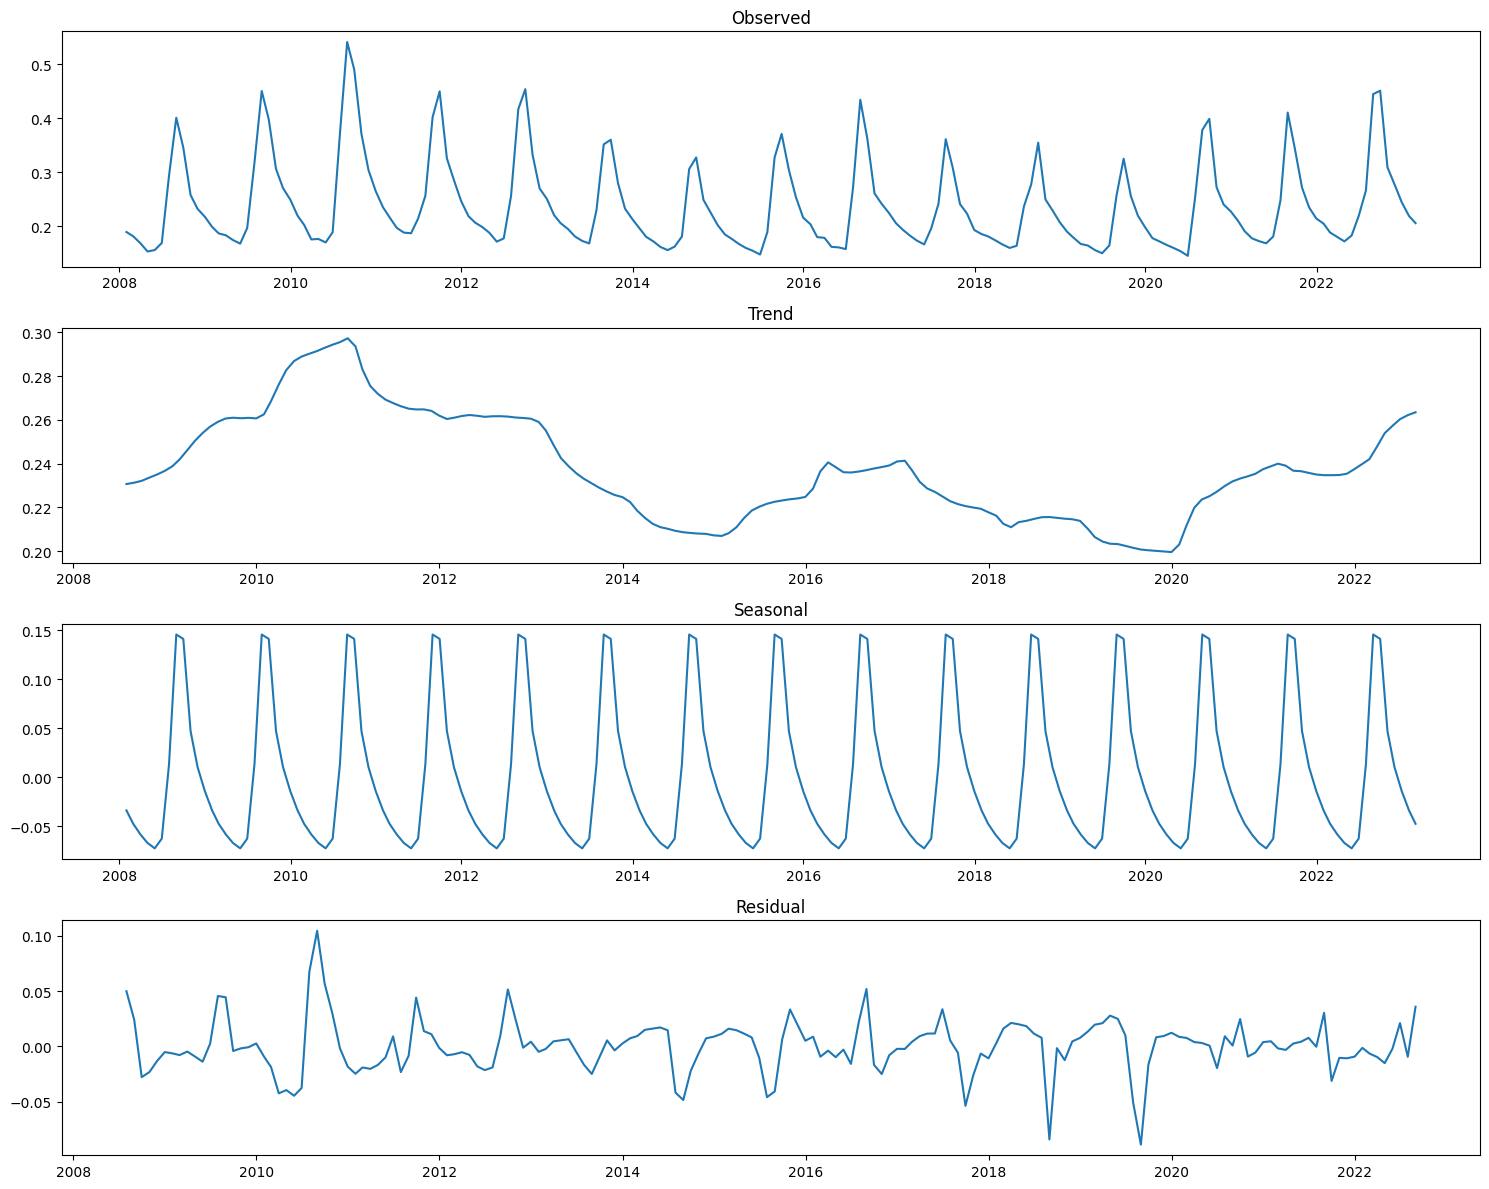

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

data = pd.read_csv('merged_FN.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

monthly_data_ndvi = data['mean_ndvi_FN'].resample('M').mean()

# seasonal decomposing
decomposition = seasonal_decompose(monthly_data_ndvi, model='additive')

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
ax1.plot(decomposition.observed)
ax1.set_title('Observed')
ax2.plot(decomposition.trend)
ax2.set_title('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_title('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

In [2]:
data = pd.read_csv('merged_FN.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
monthly_data_ndvi = data['mean_ndvi_FN'].resample('M').mean()

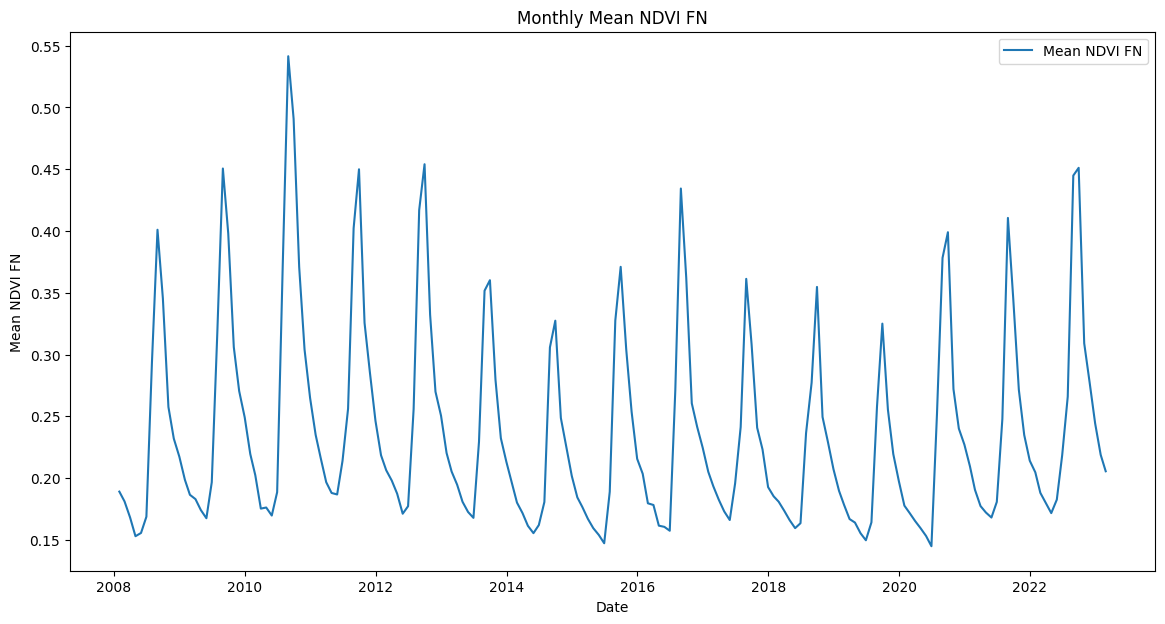

In [3]:
# Visualise
def visualize_data(monthly_data, title):
    plt.figure(figsize=(14, 7))
    plt.plot(monthly_data, label=title)
    plt.title(f'Monthly {title}')
    plt.xlabel('Date')
    plt.ylabel(title)
    plt.legend()
    plt.show()
    
visualize_data(monthly_data_ndvi, 'Mean NDVI FN')

                                        SARIMAX Results                                        
Dep. Variable:                            mean_ndvi_FN   No. Observations:                  182
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2], 12)   Log Likelihood                 359.650
Date:                                 Tue, 20 Aug 2024   AIC                           -709.300
Time:                                         21:36:53   BIC                           -694.019
Sample:                                     01-31-2008   HQIC                          -703.094
                                          - 02-28-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7092      0.046     15.571      0.000       0.620       0

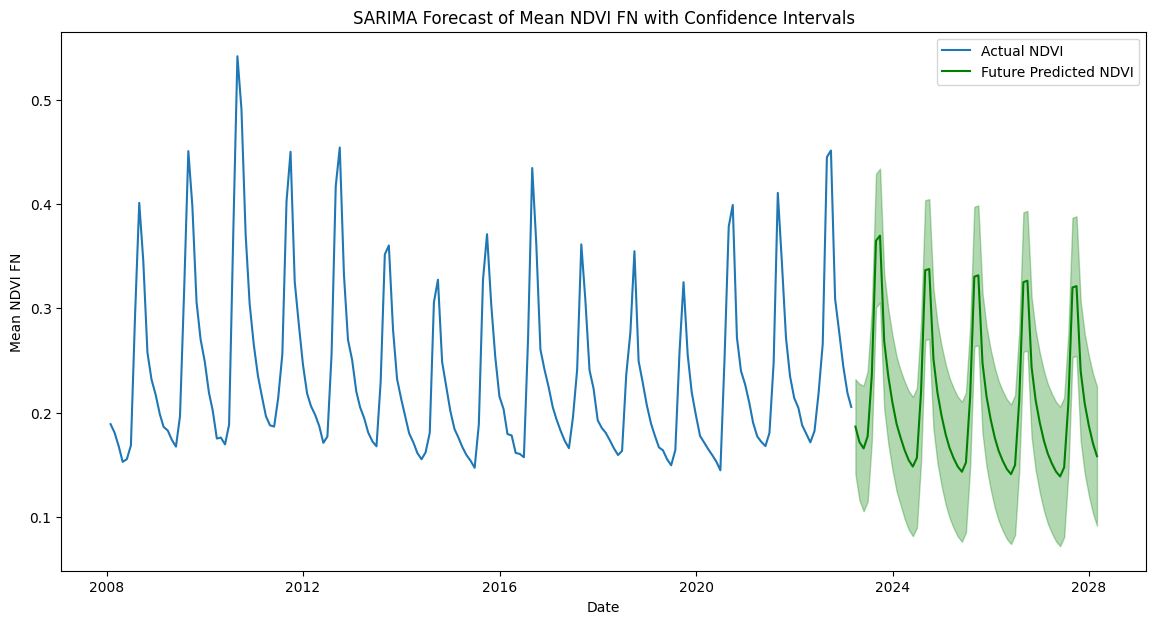

In [4]:
# Function to fit SARIMAX model and forecast

def fit_sarima_forecast(data, title, steps=60):
    model = SARIMAX(data, order=(1, 0, 0), seasonal_order=(1, 0, 2, 12), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    print(results.summary())
    forecast = results.get_forecast(steps=steps)
    forecast_ci = forecast.conf_int()

    # Plot the forecast with confidence intervals
    plt.figure(figsize=(14, 7))
    plt.plot(data, label='Actual NDVI')
    plt.plot(forecast.predicted_mean, label='Future Predicted NDVI', color='green')
    plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.3)
    plt.title(f'SARIMA Forecast of {title} with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel(title)
    plt.legend()
    plt.show()


# Fit SARIMAX model and forecast for NDVI data
fit_sarima_forecast(monthly_data_ndvi, 'Mean NDVI FN')

                                      SARIMAX Results                                       
Dep. Variable:                         mean_ndvi_FN   No. Observations:                  182
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 379.376
Date:                              Tue, 20 Aug 2024   AIC                           -746.753
Time:                                      21:36:54   BIC                           -728.045
Sample:                                  01-31-2008   HQIC                          -739.160
                                       - 02-28-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8299      0.146      5.673      0.000       0.543       1.117
ma.L1         -0.06

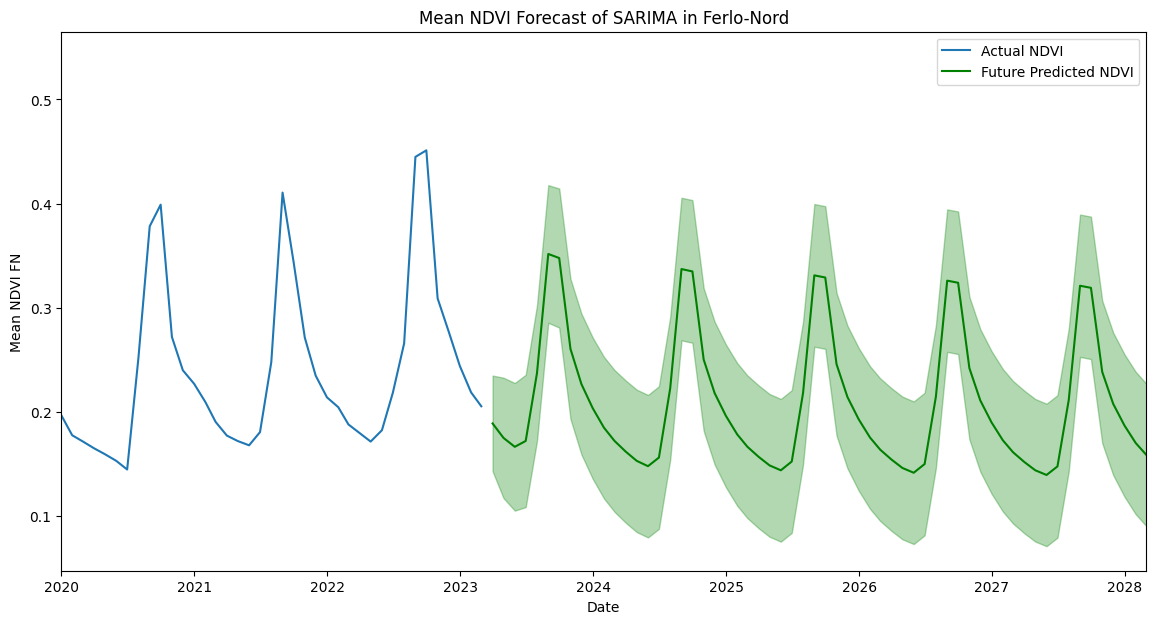

In [5]:
def fit_sarima_forecast(data, title, steps=60):
    # Fit the SARIMAX model
    model = SARIMAX(data, order=(1, 0, 2), seasonal_order=(1, 0, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    print(results.summary())
    
    # Forecast the future values
    forecast = results.get_forecast(steps=steps)
    forecast_ci = forecast.conf_int()
    
    # Plot the forecast with confidence intervals
    plt.figure(figsize=(14, 7))
    plt.plot(data, label='Actual NDVI')
    plt.plot(forecast.predicted_mean, label='Future Predicted NDVI', color='green')
    plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.3)
    plt.xlim(pd.Timestamp('2020-01-01'), forecast_ci.index[-1])
    plt.title('Mean NDVI Forecast of SARIMA in Ferlo-Nord')
    plt.xlabel('Date')
    plt.ylabel(title)

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.legend()
    plt.show()

fit_sarima_forecast(monthly_data_ndvi, 'Mean NDVI FN')
import matplotlib.dates as mdates

In [6]:
# Function to calculate RMSE, MAE, and MAPE
def calculate_rmse_mae_mape(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)
    return rmse, mae, mape

# data split
train_end = '2020-12-31'
train_data = monthly_data_ndvi[:train_end]
test_data = monthly_data_ndvi[train_end:]

# SARIMAX
model = SARIMAX(train_data, order=(1, 0, 0), seasonal_order=(1, 0, 2, 12), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

# Generating forecasts for the test period
forecast = results.get_forecast(steps=len(test_data))
forecasted_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecasted_values = forecasted_values.apply(pd.to_numeric, errors='coerce').fillna(0)
forecast_ci = forecast_ci.apply(pd.to_numeric, errors='coerce').fillna(0)

# Calculating RMSE, MAE, and MAPE
rmse, mae, mape = calculate_rmse_mae_mape(test_data, forecasted_values)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

RMSE: 0.07722685929400178
MAE: 0.06354230202907284
MAPE: 0.24315723575004547
